#### Train a single network for 3 MNIST tasks sequentially

In [1]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2

In [2]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# import tensorflow as tf
import numpy as np
from copy import deepcopy
from keras.utils import to_categorical
from sklearn.utils import shuffle
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

In [4]:
# import class Model
from model import Model

In [5]:
(x_train, y_train_lda), (x_test, y_test_lda) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],-1)
y_train = to_categorical(y_train_lda)
x_test = x_test.reshape(x_test.shape[0],-1)
y_test = to_categorical(y_test_lda)
x_train = x_train.astype(np.float32)/ 255
x_test = x_test.astype(np.float32)/ 255

trainmlp = tf.data.Dataset.from_tensor_slices((x_train, y_train, y_train)).shuffle(x_train.shape[0],reshuffle_each_iteration=True).batch(128)

# return a new mnist dataset w/ pixels randomly permuted
def permute_mnist(mnist):
    perm_inds = list(range(mnist.shape[1]))
    np.random.shuffle(perm_inds)
    mnist2 = deepcopy(mnist)
    mnist2 = np.transpose(np.array([mnist2[:,c] for c in perm_inds]))
    return mnist2

mnistb = permute_mnist(x_train)
trainmlp2 = tf.data.Dataset.from_tensor_slices((mnistb, y_train, y_train)).shuffle(x_train.shape[0],reshuffle_each_iteration=True).batch(128)


In [6]:
# classification accuracy plotting
def plot_test_acc(plot_handles):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel("Test Accuracy")
    plt.ylim(0,1)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
# train/compare vanilla sgd and ewc
def train_task(model, num_iter, disp_freq, x_train, y_train, x_test, y_test, x, y_, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore(sess) # reassign optimal weights from previous training session
        if(lams[l] == 0):
            model.set_vanilla_loss()
        else:
            model.update_ewc_loss(lams[l])
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(x_test)):
            test_accs.append(np.zeros(int(num_iter/disp_freq)))
        # train on current task
        start = 0
        end = start+100
        for iter in range(num_iter):
            start = 0
            end = start+100
            # x_in = x_train[start:end,...]
            # y_in = y_train[start:end,...]
            for i in range(len(x_train)//500):
                x_in = x_train[start:end,...]
                y_in = y_train[start:end,...]
                start +=100
                end+=100
            # batch = trainset.train.next_batch(100)
            # model.train_step.run(feed_dict={x: batch[0], y_: batch[1]})
                model.train_step.run(feed_dict={x: x_in, y_: y_in})
            # for x_in, y_in in ds:
            #     train_ewc(x_in, y_in, model, optimizer, train_loss, train_accuracy, lam=0)

            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(x_test)):
                    # feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels}
                    feed_dict={x: x_test[task], y_: y_test[task]}
                    # test_accs[task][int(iter/disp_freq)] = model.acc(x=x_test[task], y = y_test[task])
                    test_accs[task][int(iter/disp_freq)] = model.accuracy.eval(feed_dict=feed_dict)
                    c = chr(ord('A') + task)
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:int(iter/disp_freq+1)], colors[task], label="task " + c)
                    plots.append(plot_h)
                plot_test_acc(plots)
                if l == 0: 
                    plt.title("vanilla sgd")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)

In [7]:
sess =tf.compat.v1.InteractiveSession()

In [8]:
# # define input and target placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [9]:
# instantiate new model
model = Model(x, y_) # simple 2-layer network

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [10]:
# initialize variables
sess.run(tf.global_variables_initializer())

#### train on task A, test on task A

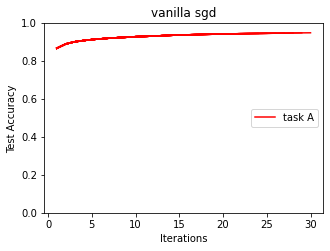

In [11]:
train_task(model, 30, 1, x_train,y_train, [x_train],[y_train],x,y_ , lams=[0])

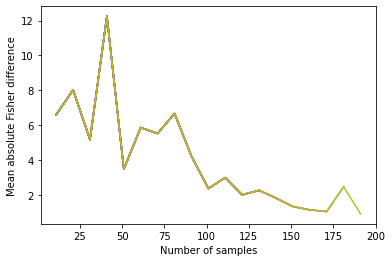

In [12]:
# Fisher information
model.compute_fisher(x_train, sess, num_samples=200, plot_diffs=True) # use validation set for Fisher computation

In [13]:
# F_row_mean = np.mean(model.F_accum[0], 1)
# mnist_imshow(F_row_mean)
# plt.title("W1 row-wise mean Fisher");

#### train on task B, test on tasks A and B

In [14]:
# permuting mnist for 2nd task
mnist2 = permute_mnist(x_train)

# plt.subplot(1,2,1)
# mnist_imshow(mnist.train.images[5])
# plt.title("original task image")
# plt.subplot(1,2,2)
# mnist_imshow(mnist2.train.images[5])
# plt.title("new task image");

In [15]:
# save current optimal weights
model.star()

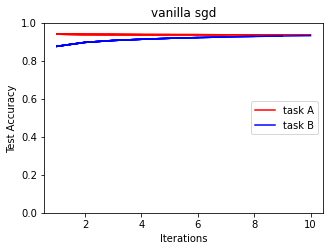

In [16]:
# training 2nd task
train_task(model, 10, 1, mnist2,y_train, [x_train, mnist2], [y_train,y_train],x, y_, lams=[0,15])

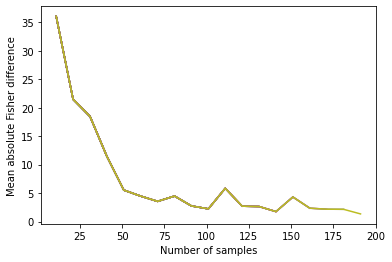

In [17]:
# Fisher information for 2nd task
model.compute_fisher(mnist2, sess, num_samples=200, plot_diffs=True)

In [18]:
F_row_mean = np.mean(model.F_accum[0], 1)
mnist_imshow(F_row_mean)
plt.title("W1 row-wise mean Fisher");

NameError: name 'mnist_imshow' is not defined

#### train on task C, test on tasks A, B, and C

In [ ]:
# permuting mnist for 3rd task
mnist3 = permute_mnist(mnist)

In [ ]:
# save current optimal weights
model.star()

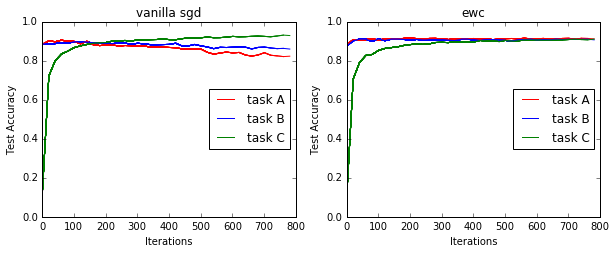

In [ ]:
# training 3rd task
train_task(model, 800, 20, mnist3, [mnist, mnist2, mnist3], x, y_, lams=[0, 15])